In [1]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import numpy as np
import math
# 변환 활성화
pandas2ri.activate()

def import_r_data():
    # 1) 필수 패키지 로드
    ro.r('library(haven)')
    # 2) R-side 데이터 로드
    ro.r('fish <- read_dta("http://www.stata-press.com/data/r11/fish.dta")')
    # 3) Python으로 변환
    fish_df = pandas2ri.rpy2py(ro.r('fish'))
    return fish_df

# 사용 예
fish = import_r_data()
print(type(fish))   # pandas.DataFrame
print(fish.head())

! curl package not installed, falling back to using `url()`
<class 'pandas.core.frame.DataFrame'>
   nofish  livebait  camper  persons  child        xb        zg  count
1     1.0       0.0     0.0      1.0    0.0 -0.896315  3.050405    0.0
2     0.0       1.0     1.0      1.0    0.0 -0.558345  1.746149    0.0
3     0.0       1.0     0.0      1.0    0.0 -0.401731  0.279939    0.0
4     0.0       1.0     1.0      2.0    1.0 -0.956298 -0.601526    0.0
5     0.0       1.0     0.0      1.0    0.0  0.436891  0.527709    1.0


In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import poisson

# ===========================
# 0) 데이터 로드 및 디자인 행렬 정의
# ===========================
# fish DataFrame이 이미 로드되어 있는 상태라고 가정합니다.
# 예시: fish = pd.read_csv("your_fish_data.csv")

y_int = fish["count"].values.astype(int) # 관측값
X = np.column_stack([np.ones(len(fish)), fish[["persons"]].values]) # 디자인 행렬 X : 여기서 person임
Z = np.column_stack([np.ones(len(fish)), fish[["camper"]].values]) # 디자인 행렬 Z : 여기서 camper임

# ===========================
# 1) ZIPAP 클래스 정의
# ===========================
class ZIPAP:
    def __init__(self, X, Z, degree=3, alpha_init_eps=1e-2):
        self.X = np.asarray(X) # 람다 회귀용
        self.Z = np.asarray(Z) # Pi 회귀용
        self.n, self.p = self.X.shape # 관측치 수 
        _, self.q = self.Z.shape # π 회귀 파라미터 γ의 차원
        self.d = degree # 다항조정자의 차수
        self.beta  = np.zeros(self.p) #  로그it(π) 회귀용 γ 벡터를 0으로 초기화
        self.gamma = np.zeros(self.q) #  로그it(π) 회귀용 γ 벡터를 0으로 초기화
        self.alpha = np.concatenate(([1.0], np.full(self.d, alpha_init_eps))) # [1.0]은 alpha_{0}부근, 나머지는 1e-2로 설정하여 알파값이 이상한 값이 나오지 않도록 설정

    def _T(self, y): # propositon 2.2; dentifiability and Validity of the Polynomial Adjuster을 구현한 부분임/
        y = np.asarray(y)
        return sum(self.alpha[k] * (y**k) for k in range(self.d+1)) # 

    def _Z(self, lam):
        lam = np.asarray(lam)
        if self.d <= 4:
            # closed-form moments
            m0 = np.ones_like(lam) # mu0(lambda) =1
            m1 = lam # mu0(lambda) = lambda
            m2 = lam**2 + lam  # mu2(lambda) = lambda^2 + lambda
            
            m3 = lam**3 + 3*lam**2 + lam
            m4 = lam**4 + 6*lam**3 + 7*lam**2 + lam

            Zval = self.alpha[0]*m0 # thm 2.3(c)의 수식으로 풀이 될 수 있음

            # 이때 차수가 d가 0,1,2,3,4일 때를 대비해 필요 모멘트 까지만 더할 수 있도록 한 코드임.
            if self.d>=1: Zval += self.alpha[1]*m1 
            if self.d>=2: Zval += self.alpha[2]*m2
            if self.d>=3: Zval += self.alpha[3]*m3
            if self.d>=4: Zval += self.alpha[4]*m4
            return Zval
        
        # numeric truncation 30 부근까지만 계산해서 보여줘야 함
        Ymax = max(30, int(np.max(lam) + 10*self.d))
        ys = np.arange(Ymax+1)

        # 이를 위한 
        pmf_vals = np.vstack([poisson.pmf(ys, lam_i) for lam_i in lam])
        T_vals = np.vstack([self._T(ys) for _ in lam])

        return (pmf_vals * T_vals).sum(axis=1)
    
    # regresion parameters과 대응됨
    def _pi_lambda(self):
        eta = self.Z.dot(self.gamma) # (logit 링크의 선형 예측자)
        pi = 1/(1+np.exp(-eta)) # logit 링크의 역함수 -> Pi 계산
        lam = np.exp(self.X.dot(self.beta)) # lambda를 양수로 보장하기 위한 로그 링크 연산
        return pi, lam

    def pmf(self, y):
        y = np.asarray(y)
        pi, lam = self._pi_lambda() # _pi_lambda(self) 의 zero inflation parameter pi와 Poisson parameter lambda를 계산값을 호출함
        T_y = self._T(y) # 다항식 가중치 함수 T 계산값에 대해서 호출함.
        Z_l = self._Z(lam) # 정규화 상수 계산값을 호출함
        p = np.zeros_like(y, float) 
        
        # 여기서부터 논문 proposition 2.1 부분의 조건문 분기를 위한 식 생성
        mask0 = (y==0) 

        if mask0.any():
            p0 = poisson.pmf(0, lam[mask0]) * T_y[mask0]/Z_l[mask0] 
            p[mask0] = pi[mask0] + (1-pi[mask0]) * p0
        
        maskp = (y>0) # y가 0보다 큰 경우를 위한 마스크
        if maskp.any():
            pp = poisson.pmf(y[maskp], lam[maskp]) * T_y[maskp]/Z_l[maskp]
            p[maskp] = (1-pi[maskp]) * pp
        return p

    def log_lik(self, theta):
        self.beta = theta[:self.p] # θ에서 beta 파라미터를 추출 -> log lambda 파라미터
        self.gamma = theta[self.p:self.p+self.q] # θ에서 gamma 파라미터를 추출 -> logit pi 파라미터
        self.alpha[1:] = np.abs(theta[self.p+self.q:]) # θ 에서 α₁…α_d 분리 및 비음수 제약 -> 다항조정자 부분 
        vals = np.clip(self.pmf(self._y), 1e-12, None) # f(Yᵢ; θ) 계산, 0으로 나누는 것을 방지하기 위해 최소값을 1e-12로 설정

        return -np.sum(np.log(vals)) # 음의 로그우도 계산
    
    # 초기화 단계: 초기 모멘트 계산
    def init_moments(self, y, alpha_init_eps):
        mu, var = y.mean(), y.var()
        pi0 = np.clip(1 - var/mu, 1e-3, 1-1e-3)
        lam0 = mu/(1-pi0)
        Xmean = self.X.mean(axis=0)
        self.gamma = np.array([np.log(pi0/(1-pi0))] + [0]*(self.q-1))
        self.beta = np.log(lam0) - np.log(Xmean)
        self.alpha = np.concatenate(([1.0], np.full(self.d, alpha_init_eps)))

    def to_theta(self):
        return np.concatenate([self.beta, self.gamma, self.alpha[1:]])

    def fit(self, y, method='L-BFGS-B', initial_alpha_eps=1e-2, retry_alpha_eps=1e-1):
        self._y = y.copy() # y값을 복사한다.
        self.init_moments(self._y, initial_alpha_eps) # 
        theta0 = self.to_theta() # 초기 파라미터 벡터 θ₀ 생성 여기서 theta0는 beta, gamma, alpha를 포함하는 벡터임.
        
        bounds = [(None,None)]*(self.p+self.q) + [(0,None)]*self.d # β, γ(로그 링크/로그릿 링크)는 아무 값이나 허용 (None,None) / alpha는 양수값 제약
        res = opt.minimize(self.log_lik, theta0, method=method, bounds=bounds) # 최적화 시도 -> method = 'L-BFGS-B'로 설정
        
        if not res.success: # 최적화 실패시 retry_alpha_eps을 사용하여 초기값을 다시 설정함.
            self.init_moments(self._y, retry_alpha_eps)
            res2 = opt.minimize(self.log_lik, self.to_theta(), method=method, bounds=bounds)
            
            # 두 번째 최적화가 성공하면 결과를 업데이트
            if res2.success:
                res = res2
            # 두번째 최적화를 했는데 안되면 Nelder-Mead 기법을 시도
            else:
                res3 = opt.minimize(self.log_lik, self.to_theta(), method='Nelder-Mead')
                if not res3.success:
                    raise RuntimeError("Optimization failed")
                res = res3
        # 최적화 성공시 각 차수에 대한 정보 저장                
        self.beta = res.x[:self.p]
        self.gamma = res.x[self.p:self.p+self.q]
        self.alpha[1:] = np.abs(res.x[self.p+self.q:])
        return res
    
    # 예측 
    def predict_mean(self):
        pi, lam = self._pi_lambda()
        return (1-pi)*lam

    # AIC, BIC 계산
    def aic(self):
        k = self.p + self.q + self.d
        return 2*k + 2*self.log_lik(self.to_theta())

    def bic(self):
        k = self.p + self.q + self.d
        return np.log(self.n)*k + 2*self.log_lik(self.to_theta())

# ===========================
# 2) Table 1: Parameter estimates for ZIP and zPAP models
# ===========================
models = {}
results = {}
degrees = [0,1,2,3]
for d in degrees:
    m = ZIPAP(X, Z, degree=d, alpha_init_eps=1e-2)
    res = m.fit(y_int, initial_alpha_eps=1e-2, retry_alpha_eps=1e-1)
    models[d] = m
    # Collect parameter estimates
    params = {
        'beta0': m.beta[0],
        'beta1': m.beta[1],
        'gamma0': m.gamma[0],
        'gamma1': m.gamma[1]
    }
    # alphas
    for k in range(1, d+1):
        params[f'alpha{k}'] = m.alpha[k]
    # stats
    params['logLik'] = -res.fun
    params['AIC'] = m.aic()
    params['BIC'] = m.bic()
    results[d] = params

# Build DataFrame
rows = ['beta0','beta1','gamma0','gamma1','alpha1','alpha2','alpha3','logLik','AIC','BIC']
col_map = {0:'ZIP',1:'zPAP(1)',2:'zPAP(2)',3:'zPAP(3)'}

df = pd.DataFrame(index=rows, columns=[col_map[d] for d in degrees])
for d in degrees:
    for r in rows:
        df.at[r, col_map[d]] = results[d].get(r, np.nan)

# Display table
print("Table 1: MLE estimates for ZIP and zPAP models")
print(df.to_markdown(floatfmt=".3f"))


Table 1: MLE estimates for ZIP and zPAP models
|        |      ZIP |   zPAP(1) |   zPAP(2) |   zPAP(3) |
|:-------|---------:|----------:|----------:|----------:|
| beta0  |   -0.368 |    -0.368 |    -0.368 |    -0.327 |
| beta1  |    0.623 |     0.623 |     0.611 |     0.590 |
| gamma0 |    0.605 |     0.605 |     0.604 |     0.604 |
| gamma1 |   -0.744 |    -0.744 |    -0.745 |    -0.745 |
| alpha1 |  nan     |     0.000 |     0.000 |     0.000 |
| alpha2 |  nan     |   nan     |     0.004 |     0.000 |
| alpha3 |  nan     |   nan     |   nan     |     0.001 |
| logLik | -671.101 |  -671.101 |  -668.619 |  -663.990 |
| AIC    | 1350.201 |  1352.201 |  1349.239 |  1341.981 |
| BIC    | 1364.287 |  1369.808 |  1370.368 |  1366.631 |


Optimization terminated successfully.
         Current function value: 3.686496
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
Poisson Mean (λ) from ZIP model: 0.3720
Poisson Mean (λ) from ZIP model: 0.3720
Zero Probability (π) from ZIP model: 0.5670


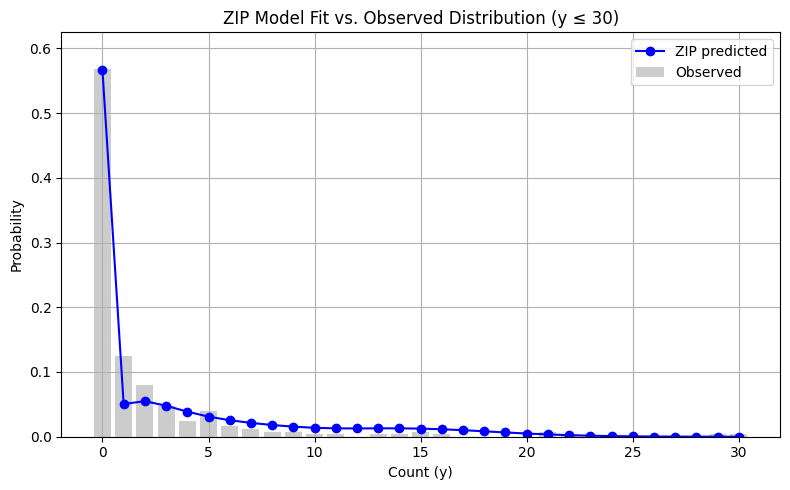

In [3]:
# 1. ZIP 모델 추정
from statsmodels.discrete.count_model import ZeroInflatedPoisson

zip_model = ZeroInflatedPoisson(endog=y_int, exog=X, exog_infl=Z, inflation='logit')
zip_result = zip_model.fit()

zip_result.summary()

ys = np.arange(0, np.max(y_int) + 1)

# 1. 관측 분포
obs_counts = np.bincount(y_int.astype(int), minlength=len(ys))
obs_probs = obs_counts / obs_counts.sum()

# 2. ZIP 평균 예측 분포
zip_probs = zip_model.predict(
    params=zip_result.params,
    exog=X,
    exog_infl=Z,
    which='prob'
)  # shape: (n_samples, n_counts)
zip_probs_avg = np.mean(zip_probs, axis=0)

# 1. 회귀 계수 β 추출 (exog는 count model)
beta_hat = zip_result.params[:X.shape[1]]

# 2. 각 관측치의 λᵢ 계산
lambda_hat = np.exp(X @ beta_hat)

# 3. 평균 λ
lambda_mean = np.mean(lambda_hat)
print(f"Poisson Mean (λ) from ZIP model: {lambda_mean:.4f}")

ys = np.arange(0, np.max(y_int) + 1)

# 1. 관측 분포
obs_counts = np.bincount(y_int.astype(int), minlength=len(ys))
obs_probs = obs_counts / obs_counts.sum()

# 2. ZIP 평균 예측 분포
zip_probs = zip_model.predict(
    params=zip_result.params,
    exog=X,
    exog_infl=Z,
    which='prob'
)  # shape: (n_samples, n_counts)
zip_probs_avg = np.mean(zip_probs, axis=0)

# 1. 회귀 계수 β 추출 (exog는 count model)
beta_hat = zip_result.params[:X.shape[1]]

# 2. 각 관측치의 λᵢ 계산
lambda_hat = np.exp(X @ beta_hat)

# 3. 평균 λ
lambda_mean = np.mean(lambda_hat)
print(f"Poisson Mean (λ) from ZIP model: {lambda_mean:.4f}")

pi_hat = np.mean(zip_probs[:, 0])
print(f"Zero Probability (π) from ZIP model: {pi_hat:.4f}")

import matplotlib.pyplot as plt
import numpy as np

# 0~30 범위로 설정
ys = np.arange(0, 31)

# 관측 분포
obs_counts = np.bincount(y_int.astype(int), minlength=31)
obs_probs = obs_counts / obs_counts.sum()

# ZIP 예측 분포 (전체 중 앞 31개)
zip_probs = zip_model.predict(
    params=zip_result.params,
    exog=X,
    exog_infl=Z,
    which='prob'
)
zip_probs_avg = np.mean(zip_probs, axis=0)[:31]

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(ys, obs_probs[:31], width=0.8, alpha=0.4, label="Observed", color="gray")
plt.plot(ys, zip_probs_avg, marker="o", linestyle="-", color="blue", label="ZIP predicted")
plt.xlabel("Count (y)")
plt.ylabel("Probability")
plt.title("ZIP Model Fit vs. Observed Distribution (y ≤ 30)")
plt.ylim(0, max(obs_probs[:31].max(), zip_probs_avg.max()) * 1.1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


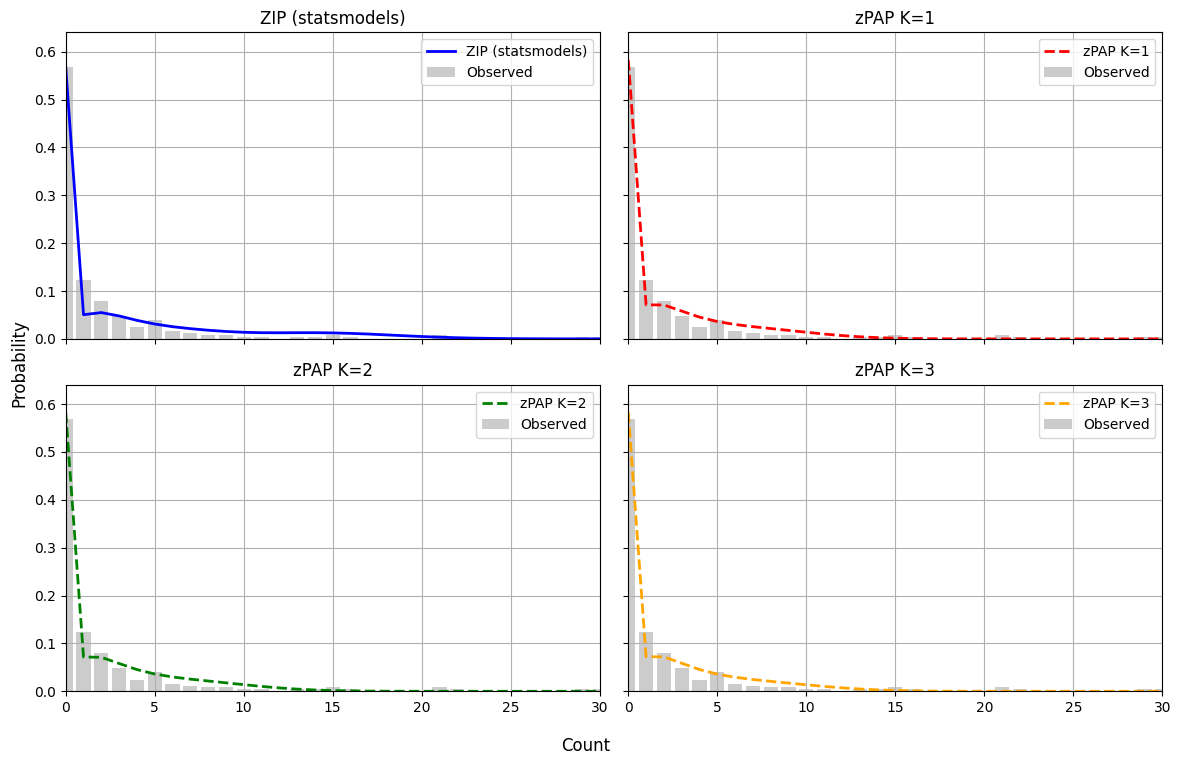

In [4]:
# 0~30 구간만
ys = np.arange(0, 31)

# 관측 빈도
obs_counts = np.bincount(y_int.astype(int), minlength=31)
obs_freq = obs_counts / obs_counts.sum()

# statsmodels ZIP 예측 확률 (n, y) → 평균
zip_probs = zip_model.predict(params=zip_result.params, exog=X, exog_infl=Z, which='prob')
zip_probs_avg = np.mean(zip_probs, axis=0)[:31]

# zPAP 계열 PMF 추정
def pmf_population(model, y_vals):
    pi, lam = model._pi_lambda()
    Z_l = model._Z(lam)
    out = []
    for y in y_vals:
        T_y = model._T(np.array([y]))
        if y == 0:
            p_i = pi + (1 - pi) * poisson.pmf(0, lam) * T_y / Z_l
        else:
            p_i = (1 - pi) * poisson.pmf(y, lam) * T_y / Z_l
        out.append(p_i.mean())
    return np.array(out)

# 모델 학습 및 PMF
degrees = [1, 2, 3]
colors = {0: "blue", 1: "red", 2: "green", 3: "orange"}
pmfs = {}
for d in degrees:
    m = ZIPAP(X, Z, degree=d, alpha_init_eps=1e-1)
    m.fit(y_int, method='L-BFGS-B', initial_alpha_eps=1e-2, retry_alpha_eps=1e-1)
    pmfs[d] = pmf_population(m, ys)

# --- 시각화 ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# (0, 0) ZIP: statsmodels 예측
ax = axes[0, 0]
ax.bar(ys, obs_freq[:31], color="gray", alpha=0.4, label="Observed")
ax.plot(ys, zip_probs_avg, label="ZIP (statsmodels)", color="blue", linestyle='-', linewidth=2)
ax.set_title("ZIP (statsmodels)")
ax.set_xlim(0, 30)
ax.set_ylim(0, max(obs_freq.max(), zip_probs_avg.max()) * 1.1)
ax.grid(True); ax.legend()

# 나머지 zPAP(1~3)
for i, d in enumerate(degrees):
    ax = axes[(i+1)//2, (i+1)%2]
    lbl = f"zPAP K={d}"
    ax.bar(ys, obs_freq[:31], color="gray", alpha=0.4, label="Observed")
    ax.plot(ys, pmfs[d], label=lbl, color=colors[d], linestyle='--', linewidth=2)
    ax.set_xlim(0, 30)
    ax.set_ylim(0, max(obs_freq[:31].max(), max(pmfs[d])) * 1.1)
    ax.set_title(lbl)
    ax.grid(True); ax.legend()

fig.supxlabel("Count")
fig.supylabel("Probability")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### 멀티모달

 d | lambda  |   pi    |    logLik    |    AIC    |     MSE     |       α vector
---+---------+---------+--------------+-----------+-------------+------------------------
 0 |  8.2507 |  0.2873 |   -1460.4555 |   2924.91 |  4.2015e-04 | [1.]
 1 |  8.2507 |  0.2873 |   -1460.4555 |   2926.91 |  4.2015e-04 | [1. 0.]
 2 |  8.2507 |  0.2873 |   -1460.4555 |   2928.91 |  4.2015e-04 | [ 1. -0.  0.]
 3 |  6.8084 |  0.2843 |   -1349.3655 |   2708.73 |  1.7536e-04 | [ 1.     -0.2958  0.0237  0.    ]
 4 |  6.1499 |  0.2739 |   -1317.8062 |   2647.61 |  7.6234e-05 | [ 1.000e+00 -6.428e-01  1.525e-01 -1.550e-02  6.000e-04]


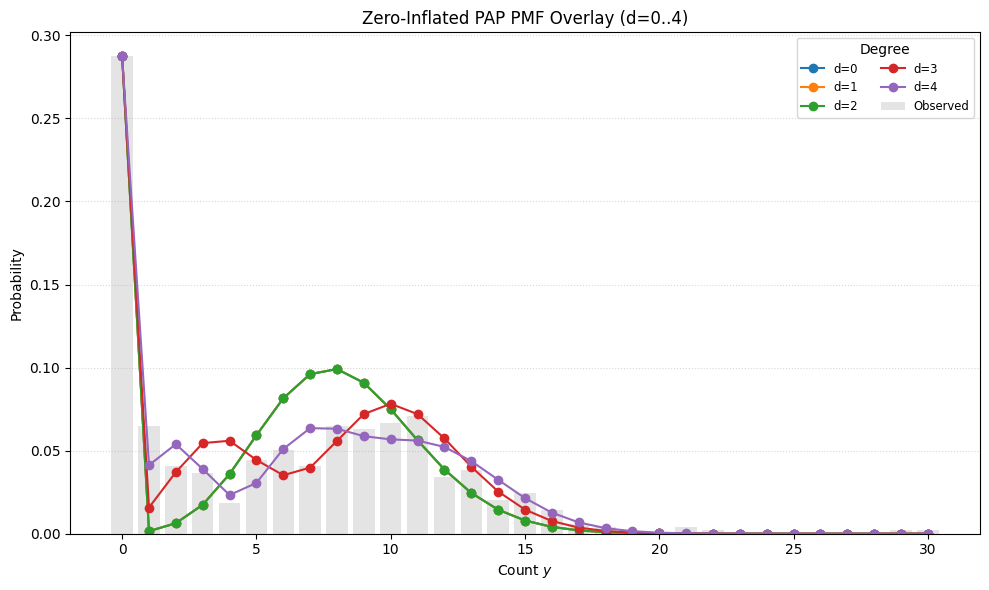

In [5]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import poisson
from functools import lru_cache

# ============================================================
# 0) 데이터 로드 및 전처리 (y=0..30)
# ============================================================
counts = fish["count"].astype(int).values # fish data 생성
rng    = np.random.RandomState(42) # 랜덤샘플링을 시도할 때 
y_p10  = rng.poisson(lam=10, size=len(counts))

y_all  = np.concatenate([counts, y_p10])
y_all  = y_all[(y_all >= 0) & (y_all <= 30)]   # 0 포함, 상한 30

# ============================================================
# 1) Poisson raw‐moments via Stirling numbers
# ============================================================
# 이전코드에서는 하드코딩으로 모멘트 합을 구했지만, 차후 대용량 데이터를 반영하게 되면 연산량이 많아지게 됨. 그렇기에 스털링 수를 사용해서 빠른 연산이 되도록 도와준다.
# 그냥 모멘트 합이라고 생각하면 쉬움

@lru_cache(None) # 
def S(n, k): # 
    if n==k==0: return 1 # 
    if n==0 or k==0 or k>n: return 0 # 
    return S(n-1, k-1) + k*S(n-1, k) # 


def poisson_raw_moment(j, lam): # 
    lam = np.asarray(lam, float) 
    if j==0: return np.ones_like(lam)
    if j==1: return lam
    if j==2: return lam**2 + lam
    if j==3: return lam**3 + 3*lam**2 + lam
    out = np.zeros_like(lam)
    for k in range(j+1):
        out += S(j,k)*lam**k
    return out

# ============================================================
# 2) SoS 전개로 α 벡터 계산
# ============================================================
# Sum of Square (SoS) 전개를 사용하여 α 벡터를 계산하는 함수
def compute_alpha(u, v):
    r0, r1 = len(u)-1, len(v)-1
    d = max(2*r0, 1+2*r1)
    α = np.zeros(d+1)
    α[0] = 1.0
    # s0^2
    for i in range(r0+1):
        for j in range(r0+1):
            if i==0 and j==0: continue
            α[i+j] += u[i]*u[j]
    # y·s1^2
    for p in range(r1+1):
        for q in range(r1+1):
            α[p+q+1] += v[p]*v[q]
    return α

# ============================================================
# 3) Zero‐Inflated PAP Negative Log‐Likelihood
# ============================================================

def zipap_negloglik(theta, y, r0, r1):
    # unpack
    loglam   = theta[0] # 단일 λ 값을 추정하므로, 그냥 loglam 하나만 가지고 전역 λ 를 np.exp(loglam) 으로 복원
    u1       = theta[1:1+r0]
    v        = theta[1+r0:1+r0+(r1+1)]
    logit_pi = theta[-1]
    lam      = np.exp(loglam) # loglam 은 단일한 로그 Poisson rate 파라미터
    pi       = 1/(1+np.exp(-logit_pi)) # logit_pi 는 단일한 로그릿(zero‐inflation 확률) 파라미터 

    u        = np.concatenate(([1.0], u1)) # u 벡터는 1.0을 포함한 벡터
    α_vec    = compute_alpha(u, v) # 알파연산 함수

    # normalization Z = Σ α_j E[Y^j] -> 정규화 상수 Z(lambdam, alpha)
    Z = sum(α_vec[j]*poisson_raw_moment(j, lam) for j in range(len(α_vec)))

    ll = 0.0 # 로그함수 값 초기화
    for yi in y: # 각 관측치에 대해서 계산
        # 다항식 가중치 T(y) 계산 -> SoS 전개를 사용하여 T(y) 계산
        T = u.dot([yi**k for k in range(len(u))])**2
        if len(v)>0:
            T += yi*(v.dot([yi**k for k in range(len(v))])**2)

        # PAP‐Poisson 결합 밀도 (unnormalized) 이때 Base rk : 논문 9page 구성
        base = T * poisson.pmf(yi, lam) / Z

        # 0부근 
        if yi==0:
            p = pi + (1-pi)*base
        
        # 0 제외 부분 피팅
        else:
            p = (1-pi)*base
        ll += np.log(p + 1e-16) # 수치적 안정성을 위해서 1e-16을 지정
    
    return -ll # 로그우도 값 생성

class ZIPAP:
    def __init__(self, degree, y):
        self.r0 = degree//2
        self.r1 = (degree-1)//2 if degree>0 else -1
        self.y  = y
        # θ = [loglam, u1..u_r0, v0..v_r1, logit_pi]
        self.theta = np.zeros(1+self.r0+(self.r1+1)+1)

    def fit(self):
        res = minimize(
            zipap_negloglik,
            self.theta,
            args=(self.y, self.r0, self.r1),
            method='L-BFGS-B'
        )
        if not res.success:
            raise RuntimeError("Optimization failed: "+res.message)
        self.theta = res.x
        return res

    def pmf(self, yi):
        loglam   = self.theta[0]
        u1       = self.theta[1:1+self.r0]
        v        = self.theta[1+self.r0:1+self.r0+(self.r1+1)]
        logit_pi = self.theta[-1]
        lam      = np.exp(loglam)
        pi       = 1/(1+np.exp(-logit_pi))
        u        = np.concatenate(([1.0], u1))
        α_vec    = compute_alpha(u, v)
        Z        = sum(α_vec[j]*poisson_raw_moment(j, lam) for j in range(len(α_vec)))
        T        = u.dot([yi**k for k in range(len(u))])**2
        
        if len(v)>0:
            T += yi*(v.dot([yi**k for k in range(len(v))])**2)
        base = T * poisson.pmf(yi, lam) / Z
        return (pi + (1-pi)*base) if yi==0 else (1-pi)*base

# ============================================================
# 4) degree=0..4 모델 학습 & 평가
# ============================================================
y_grid = np.arange(0,31)
hist, _ = np.histogram(y_all, bins=np.arange(-0.5,31.5,1), density=True)

results = []
models  = {}
for d in range(5):
    m = ZIPAP(degree=d, y=y_all)
    res = m.fit()
    models[d] = m

    # 추정된 λ, π
    lam_est = np.exp(m.theta[0])
    pi_est  = 1/(1 + np.exp(-m.theta[-1]))

    ll      = -zipap_negloglik(m.theta, y_all, m.r0, m.r1)
    K       = len(m.theta)
    AIC     = 2*K - 2*ll
    pmf_vals = np.array([m.pmf(yi) for yi in y_grid])
    MSE     = np.mean((hist - pmf_vals)**2)

    # α 벡터
    u1     = m.theta[1:1+m.r0]
    v      = m.theta[1+m.r0:1+m.r0+(m.r1+1)]
    α_vec  = compute_alpha(np.concatenate(([1.0],u1)), v)

    results.append({
        'degree': d,
        'lambda': lam_est,
        'pi': pi_est,
        'logLik': ll,
        'AIC':    AIC,
        'MSE':    MSE,
        'alpha':  α_vec
    })

# 콘솔 테이블 출력
print(" d | lambda  |   pi    |    logLik    |    AIC    |     MSE     |       α vector")
print("---+---------+---------+--------------+-----------+-------------+------------------------")
for r in results:
    d, lam, pi, ll, AIC, MSE, α = r['degree'], r['lambda'], r['pi'], r['logLik'], r['AIC'], r['MSE'], r['alpha']
    print(f"{d:2d} | {lam:7.4f} | {pi:7.4f} | {ll:12.4f} | {AIC:9.2f} | {MSE:11.4e} | {np.round(α,4)}")

# ============================================================
# 5) PMF 오버레이 플롯 (ZIPAP d=0..4)
# ============================================================
plt.figure(figsize=(10,6))
plt.bar(y_grid, hist, width=0.8, color='lightgray', alpha=0.6, label='Observed')
for d, mdl in models.items():
    pmf_d = [mdl.pmf(yi) for yi in y_grid]
    plt.plot(y_grid, pmf_d, marker='o', label=f'd={d}')
plt.xlabel('Count $y$')
plt.ylabel('Probability')
plt.title('Zero‐Inflated PAP PMF Overlay (d=0..4)')
plt.legend(title='Degree', fontsize='small', ncol=2)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

### 부트스트래핑 한 함수

In [7]:
results[4]

{'degree': 4,
 'lambda': np.float64(6.149858270970907),
 'pi': np.float64(0.27388651388782204),
 'logLik': np.float64(-1317.806184756047),
 'AIC': np.float64(2647.612369512094),
 'MSE': np.float64(7.623412739950855e-05),
 'alpha': array([ 1.00000000e+00, -6.42842657e-01,  1.52540141e-01, -1.54677343e-02,
         5.83839678e-04])}

In [9]:
import numpy as np
import time

def bootstrap_zipap_until_success(y, degree, n_boot=200, init_theta=None, random_seed=42,
                                  alpha_thresh=1e3, max_tries=1000, report_every=100):
    """
    부트스트랩을 시도하되, 성공한 샘플이 n_boot이 될 때까지 반복합니다.
    모든 반복에서 init_theta를 초기값으로 사용하며,
    report_every 간격으로 소요 시간을 출력합니다.
    """
    rng = np.random.RandomState(random_seed) if random_seed is not None else np.random.RandomState()

    n = len(y)
    r0 = degree // 2
    r1 = (degree - 1) // 2 if degree > 0 else -1
    alpha_len = max(2 * r0, 1 + 2 * r1) + 1

    lam_list, pi_list, alpha_list = [], [], []
    tries = 0
    start_time = time.perf_counter()
    last_report = start_time

    while len(lam_list) < n_boot and tries < max_tries:
        tries += 1
        yb = rng.choice(y, size=n, replace=True)
        model = ZIPAP(degree=degree, y=yb)
        if init_theta is not None:
            model.theta = init_theta.copy()
        try:
            res = model.fit()
            if not res.success or np.any(np.isnan(res.x)) or np.any(np.abs(res.x) > 1e3):
               continue
            lam_i = np.exp(res.x[0])
            pi_i  = 1 / (1 + np.exp(-res.x[-1]))
            u1 = res.x[1:1 + r0]
            v  = res.x[1 + r0:1 + r0 + (r1 + 1)]
            alpha_i = compute_alpha(np.concatenate(([1.0], u1)), v)
            if np.any(np.abs(alpha_i) > alpha_thresh):
                continue

            lam_list.append(lam_i)
            pi_list.append(pi_i)
            alpha_list.append(alpha_i)
            idx = len(lam_list)
            print(f"Success {idx}/{n_boot} (Try {tries})")

            # report_every 간격마다 시간 측정
            if idx % report_every == 0:
                now = time.perf_counter()
                print(f"  → Collected {idx} samples in {tries} tries, "
                      f"time elapsed: {now - last_report:.2f}s (since last {report_every}) "
                      f"/ total {now - start_time:.2f}s")
                last_report = now

        except RuntimeError:
            continue

    total_time = time.perf_counter() - start_time
    print(f"\n✅ Collected {len(lam_list)}/{n_boot} samples in {tries} tries, "
          f"total time: {total_time:.2f}s")
    return {
        'lambda':      np.array(lam_list),
        'pi':          np.array(pi_list),
        'alpha':       np.vstack(alpha_list) if alpha_list else np.empty((0, alpha_len)),
        'success_count': len(lam_list),
        'tries':       tries,
        'total_time_s': total_time
    }


In [10]:
full_model = ZIPAP(degree=4, y=y_all)
res_full   = full_model.fit()
theta_init = res_full.x.copy()   # <-- logλ, u₁…uᵣ₀, v₀…vᵣ₁, logitπ

### 

In [10]:
import time
import numpy as np

def bootstrap_zipap_with_params_and_timing(
    y, degree, n_boot=200, init_theta=None, random_seed=None,
    alpha_thresh=1e3, max_tries=1000, report_interval=100
):
    """
    부트스트랩을 시도하며, 매 반복마다
      - iteration time
      - 성공 시 해당 λ, π, α 벡터 출력
    report_interval마다 구간/누적 시간도 함께 찍습니다.
    """
    rng = np.random.RandomState(random_seed) if random_seed is not None else np.random.RandomState()
    n = len(y)
    r0 = degree // 2
    r1 = (degree - 1)//2 if degree>0 else -1
    alpha_len = max(2*r0, 1+2*r1) + 1

    lam_list, pi_list, alpha_list = [], [], []
    tries = 0

    t0_total = time.perf_counter()
    t0_chunk = t0_total

    while len(lam_list) < n_boot and tries < max_tries:
        tries += 1
        t0 = time.perf_counter()

        yb = rng.choice(y, size=n, replace=True)
        model = ZIPAP(degree=degree, y=yb)
        if init_theta is not None:
            model.theta = init_theta.copy()

        success = False
        try:
            res = model.fit()
            if not res.success or np.any(np.isnan(res.x)) or np.any(np.abs(res.x)>1e3):
                raise RuntimeError

            lam_i = np.exp(res.x[0])
            pi_i  = 1/(1+np.exp(-res.x[-1]))
            u1 = res.x[1:1+r0]
            v  = res.x[1+r0:1+r0+(r1+1)]
            alpha_i = compute_alpha(np.concatenate(([1.0],u1)), v)
            if np.any(np.abs(alpha_i)>alpha_thresh):
                raise RuntimeError

            lam_list.append(lam_i)
            pi_list.append(pi_i)
            alpha_list.append(alpha_i)
            success = True

        except RuntimeError:
            pass

        dt = time.perf_counter() - t0
        if success:
            idx = len(lam_list)
            print(f"Success {idx}/{n_boot} (Try {tries}, {dt:.3f}s): "
                  f"λ={lam_i:.4f}, π={pi_i:.4f}, α={np.round(alpha_i,4)}")
        else:
            print(f"Try {tries}: failed, {dt:.3f}s")

        # report_interval마다
        if len(lam_list)>0 and len(lam_list)%report_interval==0:
            t_now = time.perf_counter()
            print(f">>> Collected {len(lam_list)} in {t_now-t0_chunk:.2f}s "
                  f"(chunk), {t_now-t0_total:.2f}s total")
            t0_chunk = t_now

    t_total = time.perf_counter() - t0_total
    print(f"\n✅ Done: {len(lam_list)}/{n_boot} in {t_total:.2f}s ({tries} tries)")

    return {
        'lambda':       np.array(lam_list),
        'pi':           np.array(pi_list),
        'alpha':        np.vstack(alpha_list) if alpha_list else np.empty((0,alpha_len)),
        'success_count':len(lam_list),
        'tries':        tries,
        'time_total_s': t_total
    }

In [11]:
res = bootstrap_zipap_with_params_and_timing(
    y_all,
    degree=4,
    n_boot=1000,
    init_theta= theta_init,   # 원 데이터 MLE
    random_seed=42,
    alpha_thresh=1e3,
    max_tries=1000,
    report_interval=100   # 100개 모일 때마다 시간 출력
)

Success 1/1000 (Try 1, 4.132s): λ=5.9765, π=0.2434, α=[ 1.000e+00 -6.675e-01  1.627e-01 -1.690e-02  7.000e-04]
Success 2/1000 (Try 2, 4.764s): λ=5.6138, π=0.2623, α=[ 1.000e+00 -6.968e-01  1.771e-01 -1.910e-02  8.000e-04]
Success 3/1000 (Try 3, 2.267s): λ=6.1512, π=0.2738, α=[ 1.000e+00 -6.407e-01  1.506e-01 -1.510e-02  6.000e-04]
Success 4/1000 (Try 4, 5.357s): λ=7.7511, π=0.3079, α=[ 1.000e+00 -5.016e-01  9.270e-02 -7.200e-03  2.000e-04]
Success 5/1000 (Try 5, 5.214s): λ=6.4793, π=0.2795, α=[ 1.000e+00 -6.088e-01  1.381e-01 -1.340e-02  5.000e-04]
Success 6/1000 (Try 6, 4.736s): λ=5.6334, π=0.2501, α=[ 1.000e+00 -7.277e-01  1.954e-01 -2.220e-02  9.000e-04]
Success 7/1000 (Try 7, 5.118s): λ=5.9932, π=0.2615, α=[ 1.000e+00 -6.838e-01  1.706e-01 -1.800e-02  7.000e-04]
Success 8/1000 (Try 8, 4.792s): λ=5.8256, π=0.2587, α=[ 1.000e+00 -6.700e-01  1.634e-01 -1.690e-02  6.000e-04]
Success 9/1000 (Try 9, 5.047s): λ=6.1042, π=0.2676, α=[ 1.000e+00 -6.289e-01  1.501e-01 -1.560e-02  6.000e-04]
S

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def summarize_bootstrap(boot_res, true_lam=None, true_pi=None, true_alpha=None):
    """
    Bootstrap 결과 요약:
      - λ, π, α에 대한 평균(mean), 표준편차(std), 95% CI
      - empirical coverage (각 파라미터 샘플이 해당 파라미터의 CI에 포함된 비율)
      - true_* 인자가 주어지면 CI가 실제값을 포함하는지 여부
      - 파라미터 공변량 행렬 히트맵 (값 주석)
      - 열 너비를 고정한 Markdown 표 출력
    """
    lam   = boot_res['lambda']
    pi    = boot_res['pi']
    alpha = boot_res['alpha']  # shape (B, L)
    B, L  = alpha.shape

    # 1) 기본 통계량 및 CI
    lam_mean, lam_std = lam.mean(), lam.std(ddof=1)
    lam_ci = np.percentile(lam, [2.5, 97.5])

    pi_mean, pi_std = pi.mean(), pi.std(ddof=1)
    pi_ci = np.percentile(pi, [2.5, 97.5])

    alpha_stats = []
    for j in range(L):
        a_j = alpha[:, j]
        m, s = a_j.mean(), a_j.std(ddof=1)
        ci   = np.percentile(a_j, [2.5, 97.5])
        alpha_stats.append({'mean': m, 'std': s, 'ci95': ci})

    # 2) empirical coverage
    lam_emp_cov   = float(np.mean((lam >= lam_ci[0])   & (lam <= lam_ci[1])))
    pi_emp_cov    = float(np.mean((pi  >= pi_ci[0])    & (pi  <= pi_ci[1])))
    alpha_emp_cov = [
        float(np.mean((alpha[:, j] >= alpha_stats[j]['ci95'][0]) &
                      (alpha[:, j] <= alpha_stats[j]['ci95'][1])))
        for j in range(L)
    ]

    # 3) true value coverage
    lam_true_cov   = None if true_lam   is None else bool(lam_ci[0]   <= true_lam   <= lam_ci[1])
    pi_true_cov    = None if true_pi    is None else bool(pi_ci[0]    <= true_pi    <= pi_ci[1])
    alpha_true_cov = None
    if true_alpha is not None:
        alpha_true_cov = [
            bool(alpha_stats[j]['ci95'][0] <= true_alpha[j] <= alpha_stats[j]['ci95'][1])
            for j in range(L)
        ]

    # 4) 공변량 행렬 & 히트맵
    P = np.column_stack([lam, pi, alpha])
    cov_matrix = np.cov(P, rowvar=False)

    labels = ['λ','π'] + [f'α[{j}]' for j in range(L)]
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cov_matrix, aspect='equal', cmap='viridis')
    ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, f"{cov_matrix[i,j]:.2e}",
                    ha='center', va='center', fontsize=8, color='white')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.title("Parameter Covariance Matrix")
    plt.tight_layout()
    plt.show()

    # 5) Markdown 표 (열 너비 고정)
    print("| Param |   Mean   |  Std Dev  |      95% CI      | Emp. Cov. | True Cov. |")
    print("|:-----:|:--------:|:---------:|:----------------:|:---------:|:---------:|")
    print(f"|  λ    | {lam_mean:8.4f} | {lam_std:9.4f} | "
          f"[{lam_ci[0]:6.4f},{lam_ci[1]:6.4f}] |   {lam_emp_cov:.3f}   | {str(lam_true_cov):>5} |")
    print(f"|  π    | {pi_mean:8.4f} | {pi_std:9.4f} | "
          f"[{pi_ci[0]:6.4f},{pi_ci[1]:6.4f}] |   {pi_emp_cov:.3f}   | {str(pi_true_cov):>5} |")
    for j, st in enumerate(alpha_stats):
        lo, hi = st['ci95']
        emp    = alpha_emp_cov[j]
        truec  = None if alpha_true_cov is None else alpha_true_cov[j]
        print(f"| α[{j}]  | {st['mean']:8.4f} | {st['std']:9.4f} | "
              f"[{lo:6.4f},{hi:6.4f}] |   {emp:.3f}   | {str(truec):>5} |")

    # 6) 결과 딕셔너리 리턴
    return {
        'lambda':         {'mean': lam_mean, 'std': lam_std, 'ci95': tuple(lam_ci), 'emp_cov': lam_emp_cov, 'true_cov': lam_true_cov},
        'pi':             {'mean': pi_mean,  'std': pi_std,  'ci95': tuple(pi_ci),  'emp_cov': pi_emp_cov,  'true_cov': pi_true_cov},
        'alpha':          [
            {'mean': alpha_stats[j]['mean'], 'std': alpha_stats[j]['std'], 'ci95': tuple(alpha_stats[j]['ci95']),
             'emp_cov': alpha_emp_cov[j], 'true_cov': (None if alpha_true_cov is None else alpha_true_cov[j])}
            for j in range(L)
        ],
        'covariance_matrix': cov_matrix
    }


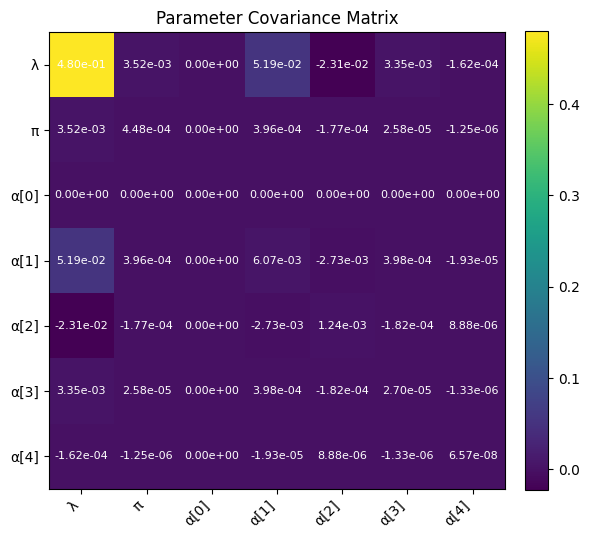

| Param |   Mean   |  Std Dev  |      95% CI      | Emp. Cov. | True Cov. |
|:-----:|:--------:|:---------:|:----------------:|:---------:|:---------:|
|  λ    |   6.3026 |    0.6931 | [5.4117,8.1405] |   0.950   |  None |
|  π    |   0.2731 |    0.0212 | [0.2328,0.3158] |   0.950   |  None |
| α[0]  |   1.0000 |    0.0000 | [1.0000,1.0000] |   1.000   |  None |
| α[1]  |  -0.6355 |    0.0779 | [-0.7626,-0.4568] |   0.950   |  None |
| α[2]  |   0.1510 |    0.0352 | [0.0766,0.2129] |   0.950   |  None |
| α[3]  |  -0.0155 |    0.0052 | [-0.0255,-0.0054] |   0.950   |  None |
| α[4]  |   0.0006 |    0.0003 | [0.0001,0.0011] |   0.950   |  None |


In [14]:
stats = summarize_bootstrap(res, true_pi=None)


In [21]:
stats['covariance_matrix']

array([[ 4.80394109e-01,  3.51851518e-03,  0.00000000e+00,
         5.19266205e-02, -2.31240587e-02,  3.35162288e-03,
        -1.61946893e-04],
       [ 3.51851518e-03,  4.47639989e-04,  0.00000000e+00,
         3.95922566e-04, -1.77020331e-04,  2.57771622e-05,
        -1.24649644e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.19266205e-02,  3.95922566e-04,  0.00000000e+00,
         6.07206804e-03, -2.72717645e-03,  3.97950196e-04,
        -1.92937560e-05],
       [-2.31240587e-02, -1.77020331e-04,  0.00000000e+00,
        -2.72717645e-03,  1.23571888e-03, -1.81799966e-04,
         8.88026025e-06],
       [ 3.35162288e-03,  2.57771622e-05,  0.00000000e+00,
         3.97950196e-04, -1.81799966e-04,  2.69570778e-05,
        -1.32633238e-06],
       [-1.61946893e-04, -1.24649644e-06,  0.00000000e+00,
        -1.92937560e-05,  8.88026025e-06, -1.32633238e-06,
         6.5712413

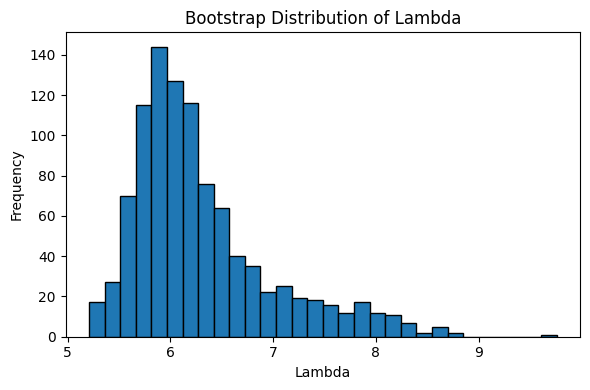

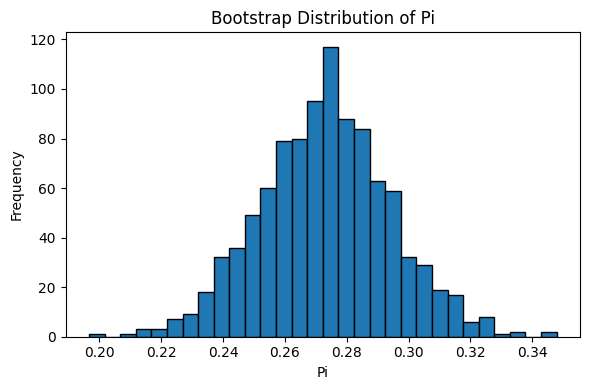

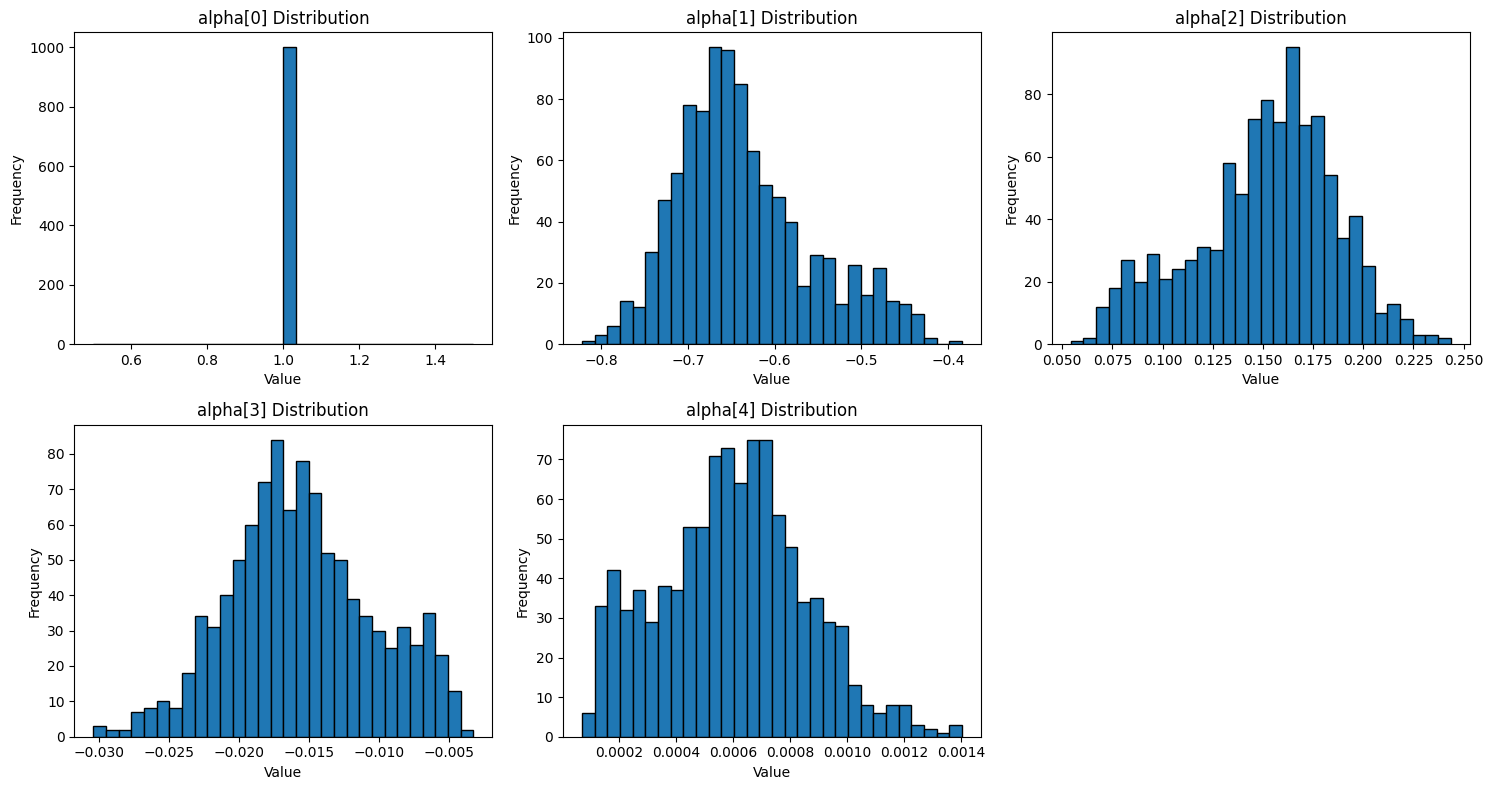

In [16]:
import math
import matplotlib.pyplot as plt

# result = bootstrap_zipap(y_all, 4, n_boot=100, random_seed=42)

# 1) 파라미터 꺼내기
lams   = res['lambda']          # shape = (100,)
pis    = res['pi']              # shape = (100,)
alphas = res['alpha']           # shape = (100, alpha_len)

# --- Lambda 히스토그램 ---
plt.figure(figsize=(6,4))
plt.hist(lams, bins=30, edgecolor='black')
plt.title('Bootstrap Distribution of Lambda')
plt.xlabel('Lambda')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Pi 히스토그램 ---
plt.figure(figsize=(6,4))
plt.hist(pis, bins=30, edgecolor='black')
plt.title('Bootstrap Distribution of Pi')
plt.xlabel('Pi')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Alpha 컴포넌트별 히스토그램 ---
num_alpha = alphas.shape[1]
ncols     = 3
nrows     = math.ceil(num_alpha / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axs = axs.flatten()

for j in range(num_alpha):
    ax = axs[j]
    ax.hist(alphas[:, j], bins=30, edgecolor='black')
    ax.set_title(f'alpha[{j}] Distribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# 남은 subplot 숨기기
for k in range(num_alpha, len(axs)):
    axs[k].axis('off')

plt.tight_layout()
plt.show()

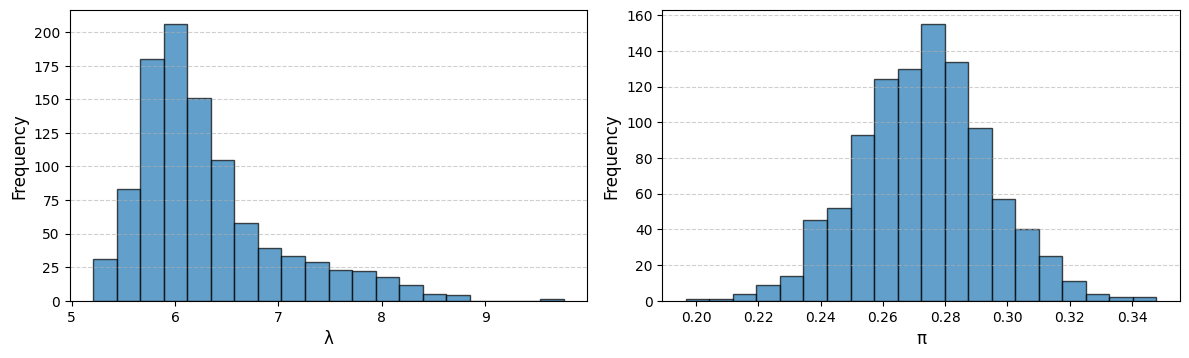

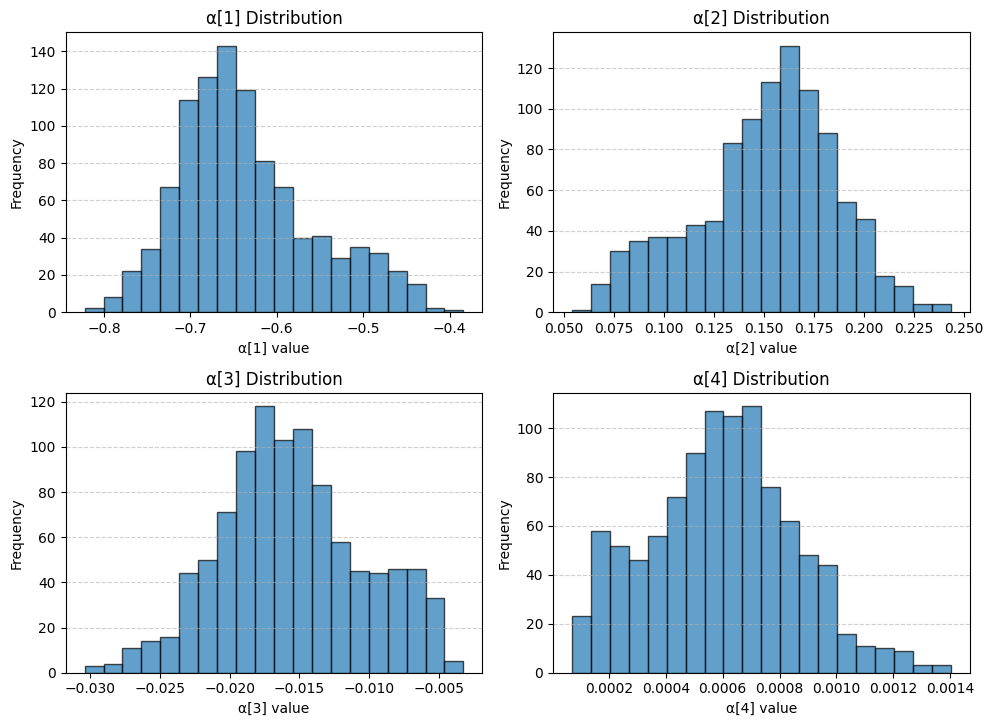

In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Assuming boot_res is already computed
lams = res['lambda']
pis = res['pi']
alphas = res['alpha']  # shape = (B, alpha_len)

# Create 1x2 grid for Lambda and Pi
fig1, axs1 = plt.subplots(1, 2, figsize=(12, 4))
# Lambda
axs1[0].hist(lams, bins=20, edgecolor='black', alpha=0.7)
axs1[0].set_xlabel('λ', fontsize=12)
axs1[0].set_ylabel('Frequency', fontsize=12)
axs1[0].grid(axis='y', linestyle='--', alpha=0.6)

# Pi
axs1[1].hist(pis, bins=20, edgecolor='black', alpha=0.7)
axs1[1].set_xlabel('π', fontsize=12)
axs1[1].set_ylabel('Frequency', fontsize=12)
axs1[1].grid(axis='y', linestyle='--', alpha=0.6)

fig1.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Exclude alpha[0] and plot alpha[1:] in 2x2 grid
alpha_vals = alphas[:, 1:]  # drop alpha[0]
num_alpha = alpha_vals.shape[1]
ncols = 2
nrows = math.ceil(num_alpha / ncols)

fig2, axs2 = plt.subplots(nrows, ncols, figsize=(10, 8))
axs2 = axs2.flatten()

for j in range(num_alpha):
    ax = axs2[j]
    ax.hist(alpha_vals[:, j], bins=20, edgecolor='black', alpha=0.7)
    ax.set_title(f'α[{j+1}] Distribution', fontsize=12)
    ax.set_xlabel(f'α[{j+1}] value', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Hide any unused subplots
for k in range(num_alpha, len(axs2)):
    axs2[k].axis('off')

fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



In [19]:
import numpy as np

# assume boot_res has keys 'lambda', 'pi', 'alpha'
lam_samps   = res['lambda']      # shape (B,)
pi_samps    = res['pi']          # shape (B,)
alpha_samps = res['alpha']       # shape (B, L)
B = len(lam_samps)

# λ summary
lam_mean = np.mean(lam_samps)
lam_std  = np.std(lam_samps, ddof=1)
lam_se   = lam_std  # bootstrap SE is just the std of replicates
lam_ci   = np.percentile(lam_samps, [2.5, 97.5])

# π summary
pi_mean = np.mean(pi_samps)
pi_std  = np.std(pi_samps, ddof=1)
pi_se   = pi_std
pi_ci   = np.percentile(pi_samps, [2.5, 97.5])

# α-vector summary
alpha_mean = np.mean(alpha_samps, axis=0)
alpha_std  = np.std(alpha_samps, axis=0, ddof=1)
alpha_se   = alpha_std
alpha_ci   = np.percentile(alpha_samps, [2.5, 97.5], axis=0)

# print results
print(f"λ    = {lam_mean:.4f}  (SE = {lam_se:.4f}, 95% CI: {lam_ci[0]:.4f}–{lam_ci[1]:.4f})")
print(f"π    = {pi_mean:.4f}  (SE = {pi_se:.4f}, 95% CI: {pi_ci[0]:.4f}–{pi_ci[1]:.4f})")
for j in range(alpha_mean.size):
    lo, hi = alpha_ci[:, j]
    print(f"α[{j}] = {alpha_mean[j]:.4f}  (SE = {alpha_se[j]:.4f}, 95% CI: {lo:.4f}–{hi:.4f})")


λ    = 6.3026  (SE = 0.6931, 95% CI: 5.4117–8.1405)
π    = 0.2731  (SE = 0.0212, 95% CI: 0.2328–0.3158)
α[0] = 1.0000  (SE = 0.0000, 95% CI: 1.0000–1.0000)
α[1] = -0.6355  (SE = 0.0779, 95% CI: -0.7626–-0.4568)
α[2] = 0.1510  (SE = 0.0352, 95% CI: 0.0766–0.2129)
α[3] = -0.0155  (SE = 0.0052, 95% CI: -0.0255–-0.0054)
α[4] = 0.0006  (SE = 0.0003, 95% CI: 0.0001–0.0011)


In [13]:
import time
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1) 부트스트랩 결과 요약 함수
# -------------------------------------------------
def summarize_bootstrap(boot_res, true_lam=None, true_pi=None, true_alpha=None, use_z_ci=False, z_val=1.96):
    """
    - boot_res: {'lambda': array(B,), 'pi': array(B,), 'alpha': array(B, L)}
    - true_lam, true_pi: 기준 파라미터 값 (None일 수 있음)
    - true_alpha: 길이 L 리스트 또는 배열 (None일 수 있음)
    - use_z_ci: True면 Normal approx (mean ± z*se), False면 percentile CI
    """
    lam   = boot_res['lambda']
    pi    = boot_res['pi']
    alpha = boot_res['alpha']
    B, L  = alpha.shape

    def compute_ci(samples, mean, std):
        if use_z_ci:
            return mean - z_val*std, mean + z_val*std
        return np.percentile(samples, [2.5, 97.5])

    # 1) 통계량 및 CI
    lam_mean, lam_std = lam.mean(), lam.std(ddof=1)
    lam_ci = compute_ci(lam, lam_mean, lam_std)
    pi_mean, pi_std = pi.mean(), pi.std(ddof=1)
    pi_ci = compute_ci(pi, pi_mean, pi_std)

    alpha_stats = []
    for j in range(L):
        a_j = alpha[:, j]
        m, s = a_j.mean(), a_j.std(ddof=1)
        ci = compute_ci(a_j, m, s)
        alpha_stats.append({'mean': m, 'std': s, 'ci95': ci})

    # 2) empirical coverage
    lam_emp_cov = np.mean((lam >= lam_ci[0]) & (lam <= lam_ci[1]))
    pi_emp_cov  = np.mean((pi  >= pi_ci[0]) & (pi  <= pi_ci[1]))
    alpha_emp_cov = [
        np.mean((alpha[:, j] >= alpha_stats[j]['ci95'][0]) &
                (alpha[:, j] <= alpha_stats[j]['ci95'][1]))
        for j in range(L)
    ]

    # 3) true coverage
    lam_true_cov = None if true_lam   is None else (lam_ci[0] <= true_lam <= lam_ci[1])
    pi_true_cov  = None if true_pi    is None else (pi_ci[0]  <= true_pi  <= pi_ci[1])
    alpha_true_cov = None
    if true_alpha is not None:
        alpha_true_cov = [
            (alpha_stats[j]['ci95'][0] <= true_alpha[j] <= alpha_stats[j]['ci95'][1])
            for j in range(L)
        ]

    # 4) covariance matrix heatmap
    P = np.column_stack([lam, pi, alpha])
    cov_matrix = np.cov(P, rowvar=False)
    labels = ['λ', 'π'] + [f'α[{j+1}]' for j in range(L)]
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cov_matrix, cmap='viridis', aspect='equal')
    ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, f"{cov_matrix[i,j]:.2e}",
                    ha='center', va='center', color='white', fontsize=8)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.title("Parameter Covariance Matrix")
    plt.tight_layout()
    plt.show()

    # 5) Markdown 표 출력
    method = "Normal approx" if use_z_ci else "Percentile"
    print(f"**CI method**: {method} (z={z_val})\n")
    print("| Param |   Mean   |  Std Dev  |      95% CI      | Emp. Cov. | True Cov. |")
    print("|:-----:|:--------:|:---------:|:----------------:|:---------:|:---------:|")
    print(f"|  λ    | {lam_mean:8.4f} | {lam_std:9.4f} | "
          f"[{lam_ci[0]:6.4f},{lam_ci[1]:6.4f}] |   {lam_emp_cov:.3f}   | {str(lam_true_cov):>5} |")
    print(f"|  π    | {pi_mean:8.4f} | {pi_std:9.4f} | "
          f"[{pi_ci[0]:6.4f},{pi_ci[1]:6.4f}] |   {pi_emp_cov:.3f}   | {str(pi_true_cov):>5} |")
    for j, st in enumerate(alpha_stats):
        lo, hi = st['ci95']
        emp = alpha_emp_cov[j]
        truec = None if alpha_true_cov is None else alpha_true_cov[j]
        print(f"| α[{j+1}] | {st['mean']:8.4f} | {st['std']:9.4f} | "
              f"[{lo:6.4f},{hi:6.4f}] |   {emp:.3f}   | {str(truec):>5} |")

    return {
        'lambda': {'mean': lam_mean,  'std': lam_std,  'ci95': lam_ci,
                   'emp_cov': lam_emp_cov,'true_cov': lam_true_cov},
        'pi':     {'mean': pi_mean,   'std': pi_std,   'ci95': pi_ci,
                   'emp_cov': pi_emp_cov, 'true_cov': pi_true_cov},
        'alpha':  [
            {'mean': st['mean'], 'std': st['std'], 'ci95': st['ci95'],
             'emp_cov': alpha_emp_cov[j],
             'true_cov': (None if alpha_true_cov is None else alpha_true_cov[j])}
            for j, st in enumerate(alpha_stats)
        ],
        'covariance_matrix': cov_matrix
    }

# -------------------------------------------------
# 2) 부트스트랩 + 요약 통합 함수
# -------------------------------------------------
def bootstrap_with_summary(
    y, degree, n_boot=200, init_theta=None, random_seed=None,
    alpha_thresh=1e3, max_tries=1000, report_interval=100,
    true_theta=None, use_z_ci=False, z_val=1.96
):
    """
    - true_theta: dict with keys 'lambda', 'pi', 'alpha' (list/array)
    - use_z_ci: z-approximation 사용 여부
    """
    rng = np.random.RandomState(random_seed) if random_seed is not None else np.random.RandomState()
    n = len(y)
    r0 = degree // 2
    r1 = (degree - 1)//2 if degree > 0 else -1
    alpha_len = max(2*r0, 1 + 2*r1) + 1

    lam_list, pi_list, alpha_list = [], [], []
    tries = 0

    t0_total = time.perf_counter()
    t0_chunk = t0_total

    # 부트스트랩 반복
    while len(lam_list) < n_boot and tries < max_tries:
        tries += 1
        t0 = time.perf_counter()

        yb = rng.choice(y, size=n, replace=True)
        model = ZIPAP(degree=degree, y=yb)
        if init_theta is not None:
            model.theta = init_theta.copy()

        success = False
        try:
            res = model.fit()
            if (not res.success
                or np.any(np.isnan(res.x))
                or np.any(np.abs(res.x) > alpha_thresh)):
                raise RuntimeError

            # 파라미터 추출
            lam_i = np.exp(res.x[0])
            pi_i  = 1 / (1 + np.exp(-res.x[-1]))
            u1 = res.x[1:1+r0]
            v  = res.x[1+r0:1+r0+(r1+1)]
            alpha_i = compute_alpha(np.concatenate(([1.0], u1)), v)

            lam_list.append(lam_i)
            pi_list.append(pi_i)
            alpha_list.append(alpha_i)
            success = True

        except Exception:
            pass

        dt = time.perf_counter() - t0
        if success:
            idx = len(lam_list)
            print(f"Success {idx}/{n_boot} (Try {tries}, {dt:.3f}s): "
                  f"λ={lam_i:.4f}, π={pi_i:.4f}, α={np.round(alpha_i,4)}")
        else:
            print(f"Try {tries}: failed, {dt:.3f}s")

        # report_interval마다 진행 상황
        if len(lam_list) > 0 and len(lam_list) % report_interval == 0:
            t_now = time.perf_counter()
            chunk = t_now - t0_chunk
            total = t_now - t0_total
            print(f">>> Collected {len(lam_list)} in {chunk:.2f}s (chunk), {total:.2f}s total")
            t0_chunk = t_now

    total_time = time.perf_counter() - t0_total
    print(f"\n✅ Done: {len(lam_list)}/{n_boot} in {total_time:.2f}s ({tries} tries)")

    boot_res = {
        'lambda': np.array(lam_list),
        'pi':     np.array(pi_list),
        'alpha':  np.vstack(alpha_list) if alpha_list else np.empty((0, alpha_len))
    }

    # 결과 요약 출력
    summarize_bootstrap(
        boot_res,
        true_lam   = (true_theta['lambda'] if true_theta else None),
        true_pi    = (true_theta['pi']     if true_theta else None),
        true_alpha = (true_theta['alpha']  if true_theta else None),
        use_z_ci   = use_z_ci,
        z_val      = z_val
    )

    return boot_res


Success 1/1000 (Try 1, 4.116s): λ=5.9765, π=0.2434, α=[ 1.000e+00 -6.675e-01  1.627e-01 -1.690e-02  7.000e-04]
Success 2/1000 (Try 2, 4.672s): λ=5.6138, π=0.2623, α=[ 1.000e+00 -6.968e-01  1.771e-01 -1.910e-02  8.000e-04]
Success 3/1000 (Try 3, 2.346s): λ=6.1512, π=0.2738, α=[ 1.000e+00 -6.407e-01  1.506e-01 -1.510e-02  6.000e-04]
Success 4/1000 (Try 4, 5.505s): λ=7.7511, π=0.3079, α=[ 1.000e+00 -5.016e-01  9.270e-02 -7.200e-03  2.000e-04]
Success 5/1000 (Try 5, 5.383s): λ=6.4793, π=0.2795, α=[ 1.000e+00 -6.088e-01  1.381e-01 -1.340e-02  5.000e-04]
Success 6/1000 (Try 6, 4.782s): λ=5.6334, π=0.2501, α=[ 1.000e+00 -7.277e-01  1.954e-01 -2.220e-02  9.000e-04]
Success 7/1000 (Try 7, 5.253s): λ=5.9932, π=0.2615, α=[ 1.000e+00 -6.838e-01  1.706e-01 -1.800e-02  7.000e-04]
Success 8/1000 (Try 8, 4.915s): λ=5.8256, π=0.2587, α=[ 1.000e+00 -6.700e-01  1.634e-01 -1.690e-02  6.000e-04]
Success 9/1000 (Try 9, 5.128s): λ=6.1042, π=0.2676, α=[ 1.000e+00 -6.289e-01  1.501e-01 -1.560e-02  6.000e-04]
S

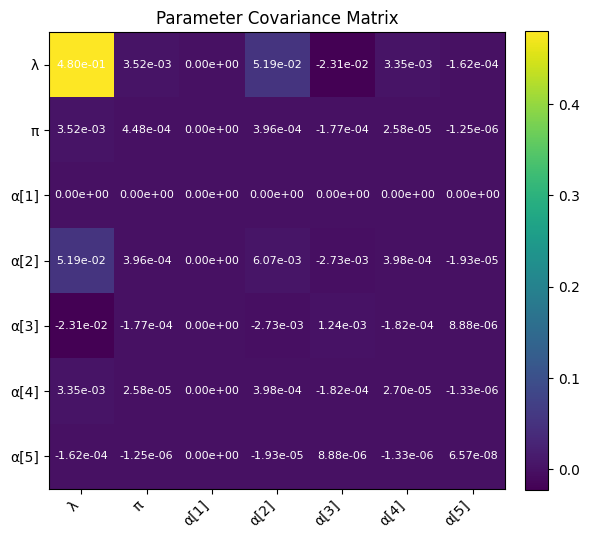

**CI method**: Normal approx (z=1.96)

| Param |   Mean   |  Std Dev  |      95% CI      | Emp. Cov. | True Cov. |
|:-----:|:--------:|:---------:|:----------------:|:---------:|:---------:|
|  λ    |   6.3026 |    0.6931 | [4.9441,7.6611] |   0.933   |  True |
|  π    |   0.2731 |    0.0212 | [0.2317,0.3146] |   0.950   |  True |
| α[1] |   1.0000 |    0.0000 | [1.0000,1.0000] |   1.000   |  True |
| α[2] |  -0.6355 |    0.0779 | [-0.7882,-0.4828] |   0.934   |  True |
| α[3] |   0.1510 |    0.0352 | [0.0821,0.2199] |   0.944   |  True |
| α[4] |  -0.0155 |    0.0052 | [-0.0257,-0.0053] |   0.954   |  True |
| α[5] |   0.0006 |    0.0003 | [0.0001,0.0011] |   0.969   |  True |


In [14]:
if __name__ == "__main__":
    # 예시 데이터 및 초기값
    init_vals = theta_init  # 모델 초기 파라미터
    true_theta = {
        'lambda': results[4]['lambda'],  # 실제 λ 값
        'pi': results[4]['pi'],     
        'alpha':  results[4]['alpha']  # 실제 α 벡터
    }

    res = bootstrap_with_summary(
        y_all, degree=4, n_boot=1000, init_theta=init_vals,
        random_seed=42, report_interval=200,
        true_theta=true_theta, use_z_ci=True, z_val=1.96
    )

In [16]:
### 

### 이번엔 몬테카를로 시뮬레이션 기법을 활용한다.